In [1]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import os
import sys
import glob
import time
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 导入数据

data = pd.read_csv('/Users/jiqiang/Nutstore Files/DULT/小论文/第一篇小论文/数据/jh_z/model training_pc_20230521/final_data_input_important_16869.csv')
# C:/Jiqiang/jh_z/jh_z/model training_pc/final_data_input_important.csv
# /Users/jiqiang/Nutstore Files/DULT/小论文/第一篇小论文/数据/jh_z/model training_pc_20230521/final_data_input_important.csv
df= pd.DataFrame(data)
counts = df['label'].value_counts()
num_zeros = counts[0]
num_ones = counts[1]
print("number of zero:",num_zeros)
print("number of one:",num_ones)

df
# 对所有数据中的输入特征进行标准化
# 选择需要标准化的列
cols_to_normalize = df.columns[1:-1]

# 实例化StandardScaler对象
scaler = StandardScaler()

# 对需要标准化的列进行标准化
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

df


number of zero: 14402
number of one: 2466


,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,0.529276,0.872868,-1.069317,2.167255,0.661314,1.258627,1.656750,1
1,1,0.603055,0.873879,-1.109121,2.298450,0.562672,1.581775,1.560669,1
2,2,0.565986,0.872344,-1.088979,2.237494,0.566401,1.432263,1.687833,1
3,3,0.677182,0.875034,-1.144304,2.387348,0.701843,1.547209,2.753982,1
4,4,0.640022,0.874624,-1.128274,2.348576,0.632812,1.548370,2.914136,1
...,...,...,...,...,...,...,...,...,...
16863,17497,-0.608630,0.857256,-0.080180,-0.611723,-0.322187,-0.045425,0.003347,0
16864,17498,-0.625218,0.851574,-0.085491,-0.578746,-0.219875,-0.009717,1.583999,0
16865,17499,-0.573010,0.865679,-0.063414,-0.726722,-0.645372,-0.178330,0.925731,0
16866,17500,-0.542297,0.871859,-0.047255,-0.772455,-0.625417,-0.308967,0.650098,0


In [3]:
# 所有特征
all_features = df.iloc[:, 1:-1]
all_features_withFID = df.iloc[:, 0:-1] 
all_features_withFID



,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0,0.529276,0.872868,-1.069317,2.167255,0.661314,1.258627,1.656750
1,1,0.603055,0.873879,-1.109121,2.298450,0.562672,1.581775,1.560669
2,2,0.565986,0.872344,-1.088979,2.237494,0.566401,1.432263,1.687833
3,3,0.677182,0.875034,-1.144304,2.387348,0.701843,1.547209,2.753982
4,4,0.640022,0.874624,-1.128274,2.348576,0.632812,1.548370,2.914136
...,...,...,...,...,...,...,...,...
16863,17497,-0.608630,0.857256,-0.080180,-0.611723,-0.322187,-0.045425,0.003347
16864,17498,-0.625218,0.851574,-0.085491,-0.578746,-0.219875,-0.009717,1.583999
16865,17499,-0.573010,0.865679,-0.063414,-0.726722,-0.645372,-0.178330,0.925731
16866,17500,-0.542297,0.871859,-0.047255,-0.772455,-0.625417,-0.308967,0.650098


In [4]:
# 从总数据中抽取1000个1和1000个0作为训练和测试，剩下的作为预测集
# 随机抽取label为0和1的数据各1000个
df1 = pd.concat([df[df['label']==0].sample(n=1000),df[df['label']==1].sample(n=1000)]) # 训练集和测试集

# 删除已经抽取的数据，剩下的放入df2中
df2 = df.drop(df1.index) # 剩下的数据作为预测集
X_pred_withFID_ = df2.iloc[:, :-1] 
X_pred = df2.iloc[:, 1:-1]
X_pred_withFID_
Y_pred = df2.iloc[:, -1]


In [5]:
# 固定训练集、测试集、预测集，将其分别输出到CSV文件中
df1.to_csv('train_test_data.csv', index=False)
df2.to_csv('predict_data.csv', index=False)

In [6]:
# 用df1中的数据划分训练集和测试集，输出到CSV文件中
from sklearn.model_selection import train_test_split

# 提取最后一列并命名为“y”
X_withFID_ = df1.iloc[:, :-1] #训练加测试加FID
X = df1.iloc[:, 1:-1] # X不带FID
Y = df1.iloc[:, -1]


X_train_withFID, X_test_withFID, Y_train, Y_test = train_test_split(X_withFID_, Y, test_size=0.2, random_state=42)

X_train = X_train_withFID.iloc[:, 1:]
X_test = X_test_withFID.iloc[:, 1:]

# 输出训练集和测试集
X_train_Y_train_withFID = pd.concat([X_train_withFID, Y_train],axis=1)
X_test_Y_test_withFID = pd.concat([X_test_withFID, Y_test],axis=1)
X_pred_Y_pred_withFID = pd.concat([X_pred_withFID_, Y_pred],axis=1)

X_train_Y_train_withFID.to_csv('train_data_FID.csv', index=False)
X_test_Y_test_withFID.to_csv('test_data_FID.csv', index=False)
X_pred_Y_pred_withFID.to_csv('predict_data_FID.csv', index=False)



In [7]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print(pd.value_counts(Y_train))

print(pd.value_counts(Y_test))

(1600, 7) (400, 7) (1600,) (400,)
0    801
1    799
Name: label, dtype: int64
1    201
0    199
Name: label, dtype: int64


In [8]:
def print_test_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def print_train_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_train) == Y_train)/len(Y_train)))
    time.sleep(0.5) # to let the print get out before any progress bars
shap.initjs()

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 将数据分为X_train, Y_train, X_test, Y_test

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier()

# 定义参数空间
param_grid = {
    'max_depth': [3, 4, 6, 8,10],
    'learning_rate': [0.5,0.1, 0.01],
    # 'min_child_weight': [1, 3, 5,7,10],
    # 'subsample': [0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1],
    #'gamma': [0, 0.1,0.3, 0.5],
    'n_estimators': [50, 100],
}

# 定义5折交叉验证策略
cv = StratifiedKFold(n_splits=5)

# 使用GridSearchCV进行自动调参和交叉验证
grid_search_xgb = GridSearchCV(xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=-1)

grid_search_xgb.fit(X_train, Y_train)

# 输出每一折的训练集和测试集准确率
for i in range(5):
    train_index, test_index = list(cv.split(X_train, Y_train))[i]

# 计算ROC曲线和AUC曲线
fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_xgb.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_xgb.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

In [10]:
grid_search_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [11]:
# 用网格搜索到的最优参数重新训练模型
params_xgb =grid_search_xgb.best_params_
best_params_xgb = xgb.XGBClassifier(**params_xgb)
best_params_xgb.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
# nn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 定义多层感知机模型
mlp = MLPClassifier()

# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001,0.01,0.1],
    'learning_rate': ['constant', 'adaptive']
}

# 定义5折交叉验证器
cv = StratifiedKFold(n_splits=5)

# 定义网格搜索器
grid_search_mlp = GridSearchCV(mlp, param_grid=param_grid,
                           cv=cv, scoring='roc_auc')

# 训练模型并进行自动调参
grid_search_mlp.fit(X_train, Y_train)

# 输出最佳参数组合和对应的AUC值
print('Best parameters:', grid_search_mlp.best_params_)
print('Best AUC:', grid_search_mlp.best_score_)

# 计算模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线等指标，并打印结果
Y_train_pred = grid_search_mlp.predict(X_train)
Y_test_pred = grid_search_mlp.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_mlp.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_mlp.predict_proba(X_test)[:, 1])


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
Best AUC: 0.8486785247348528


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [13]:
# 用网格搜索到的nn最优参数重新训练模型

params_mlp = grid_search_mlp.best_params_
best_params_mlp = MLPClassifier(**params_mlp)
best_params_mlp.fit(X_train, Y_train)



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(alpha=0.1, hidden_layer_sizes=(5,), learning_rate='adaptive',
              solver='lbfgs')

In [14]:
# LR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd

# 定义逻辑回归模型和参数网格
model = LogisticRegression()
param_grid = {'C': [ 0.01, 0.1,0.5,1]}

# 使用GridSearchCV进行自动调参和5折交叉验证
grid_search_lr = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train, Y_train)


# 绘制ROC曲线和计算AUC
fpr, tpr, thresholds = roc_curve(Y_test, grid_search_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [15]:
params_lr = grid_search_lr.best_params_
best_params_lr =  LogisticRegression(**params_lr)
best_params_lr.fit(X_train, Y_train)


LogisticRegression(C=0.1)

比较三个代表性模型的性能，如果相差很大，那就不用再加RF, SVM,如果相差不大，加上。
多个模型和多个可解释性的比较分析，用预测正确的结果进行可解释性分析。


In [16]:
# 将LR, XGB, NN的模型性能进行对比

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc

# 训练三个机器学习模型并预测测试集
model_lr = best_params_lr
model_xgb = best_params_xgb
model_mlp = best_params_mlp

Y_test_pred1 = model_lr.predict(X_test)
Y_test_pred2 = model_xgb.predict(X_test)
Y_test_pred3 = model_mlp.predict(X_test)

# 计算评价指标
accuracy_train1 = accuracy_score(Y_train, model_lr.predict(X_train))
accuracy_train2 = accuracy_score(Y_train, model_xgb.predict(X_train))
accuracy_train3 = accuracy_score(Y_train, model_mlp.predict(X_train))

accuracy_test1 = accuracy_score(Y_test, model_lr.predict(X_test))
accuracy_test2 = accuracy_score(Y_test, model_xgb.predict(X_test))
accuracy_test3 = accuracy_score(Y_test, model_mlp.predict(X_test))

precision_train1 = precision_score(Y_train, model_lr.predict(X_train))
precision_train2 = precision_score(Y_train, model_xgb.predict(X_train))
precision_train3 = precision_score(Y_train, model_mlp.predict(X_train))

precision_test1 = precision_score(Y_test, Y_test_pred1)
precision_test2 = precision_score(Y_test, Y_test_pred2)
precision_test3 = precision_score(Y_test, Y_test_pred3)

recall_train1 = recall_score(Y_train, model_lr.predict(X_train))
recall_train2 = recall_score(Y_train, model_xgb.predict(X_train))
recall_train3 = recall_score(Y_train, model_mlp.predict(X_train))

recall_test1 = recall_score(Y_test, Y_test_pred1)
recall_test2 = recall_score(Y_test, Y_test_pred2)
recall_test3 = recall_score(Y_test, Y_test_pred3)

f1score_train1 = f1_score(Y_train, model_lr.predict(X_train))
f1score_train2 = f1_score(Y_train, model_xgb.predict(X_train))
f1score_train3 = f1_score(Y_train, model_mlp.predict(X_train))

f1score_test1 = f1_score(Y_test, Y_test_pred1)
f1score_test2 = f1_score(Y_test, Y_test_pred2)
f1score_test3 = f1_score(Y_test, Y_test_pred3)

# 将评价指标存储在字典中
results_train = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (train)': [accuracy_train1, accuracy_train2, accuracy_train3],
    'Precision (train)': [precision_train1, precision_train2, precision_train3],
    'Recall (train)': [recall_train1, recall_train2, recall_train3],
    'F1 score (train)': [f1score_train1, f1score_train2, f1score_train3],
}
results_test = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (test)': [accuracy_test1, accuracy_test2, accuracy_test3],
    'Precision (test)': [precision_test1, precision_test2, precision_test3],
    'Recall (test)': [recall_test1, recall_test2, recall_test3],
    'F1 score (test)': [f1score_test1, f1score_test2, f1score_test3],
}
# 将字典转换为 Pandas 数据框
df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)


In [17]:
df_results_train

,Model,Accuracy (train),Precision (train),Recall (train),F1 score (train)
0,Model_lr,0.764375,0.780585,0.734668,0.756931
1,Model_xgb,0.876250,0.882803,0.867334,0.875000
2,Model_mlp,0.793750,0.797212,0.787234,0.792191


In [18]:
df_results_test

,Model,Accuracy (test),Precision (test),Recall (test),F1 score (test)
0,Model_lr,0.7975,0.819149,0.766169,0.791774
1,Model_xgb,0.8175,0.810680,0.830846,0.820639
2,Model_mlp,0.7975,0.800000,0.796020,0.798005


xgb_loss 0.4647332443097368
linear_loss 0.49359352939372614
dnn_loss 7.298839811296224

xgb_roc_auc 0.863321583039576
linear_roc_auc 0.8591714792869822
dnn_roc_auc 0.7975074376859421

xgb_pr_auc 0.8485467433818582
linear_pr_auc 0.8657256265754658
dnn_pr_auc 0.73931592039801



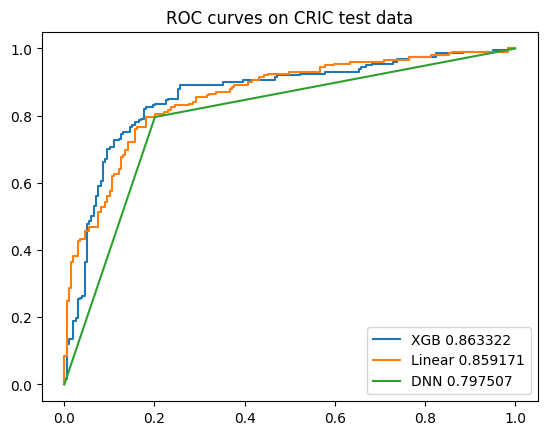

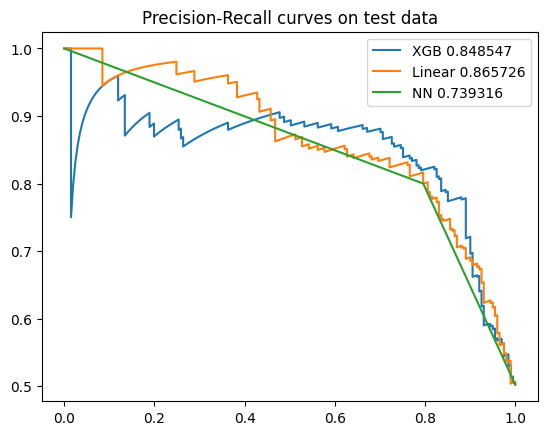

In [19]:
# Compute performance metrics
Y_test1 = Y_test.ravel() # 将Y_test1转换为一维数组
xgb_loss = sklearn.metrics.log_loss(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_loss = sklearn.metrics.log_loss(Y_test1, model_lr.predict_proba(X_test)[:,1])
nn_loss = sklearn.metrics.log_loss(Y_test1, model_mlp.predict(X_test))
# constant_loss = sklearn.metrics.log_loss(Y_test1, np.zeros(len(Y_test1)) * y_strain.mean())
print("xgb_loss", xgb_loss)
print("linear_loss", linear_loss)
print("dnn_loss", nn_loss)
print()

xgb_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_mlp.predict(X_test))
#svm_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_roc_auc", xgb_roc_auc)
print("linear_roc_auc", linear_roc_auc)
print("dnn_roc_auc", dnn_roc_auc)
#print("svm_roc_auc", svm_roc_auc)
print()

xgb_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_mlp.predict(X_test))
#svm_pr_auc = sklearn.metrics.average_precision_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_pr_auc", xgb_pr_auc)
print("linear_pr_auc", linear_pr_auc)
print("dnn_pr_auc", dnn_pr_auc)
#print("svm_pr_auc", svm_pr_auc)
print()

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_mlp.predict(X_test))
#svm_fpr, svm_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, svm_model.predict_proba(X_test))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_roc_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_roc_auc)
pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_roc_auc)
#pl.plot(svm_fpr, svm_tpr, label="SVM %f" % svm_roc_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")
pl.show()

xgb_prec, xgb_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_prec, linear_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_prec, dnn_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_mlp.predict(X_test))
#svm_prec, svm_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, svm_model.predict_proba(X_test))

pl.plot(xgb_recall, xgb_prec, label="XGB %f" % xgb_pr_auc)
pl.plot(linear_recall, linear_prec, label="Linear %f" % linear_pr_auc)
pl.plot(dnn_recall, dnn_prec, label="NN %f" % dnn_pr_auc)
#pl.plot(svm_recall, svm_prec, label="SVM %f" % svm_pr_auc)
pl.legend()
pl.title("Precision-Recall curves on test data")
pl.show()

In [20]:
# 用训练好的模型和所有预测正确的样本进行模型可解释性分析

# 训练好的模型

# 所有预测正确的样本


### 将三个模型预测准确的样本选出来分别放入一个样本集中，用于后续可解释性方法对比分析
1. 用训练好的模型预测剩余样本
2. 将所有样本（训练集、测试集、预测集）预测概率与是否预测正确输出，并于样本编号匹配
3. 挑选出预测正确的样本
4. 用不同可解释性方法对不同模型预测正确的样本进行可解释性分析

In [21]:
# 将训练、测试、预测结果与输入一起保存到output文件中
# 训练集
output_train_lr = pd.concat([X_train_withFID, Y_train, pd.Series(model_lr.predict_proba(X_train)[:,1], index=X_train_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
outpt_train_xgb = pd.concat([X_train_withFID, Y_train, pd.Series(model_xgb.predict_proba(X_train)[:,1], index=X_train_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_train_mlp = pd.concat([X_train_withFID, Y_train, pd.Series(model_mlp.predict_proba(X_train)[:,1], index=X_train_withFID.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 测试集
output_test_lr = pd.concat([X_test_withFID, Y_test, pd.Series(model_lr.predict_proba(X_test)[:,1], index=X_test_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_xgb = pd.concat([X_test_withFID, Y_test, pd.Series(model_xgb.predict_proba(X_test)[:,1], index=X_test_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_mlp = pd.concat([X_test_withFID, Y_test, pd.Series(model_mlp.predict_proba(X_test)[:,1], index=X_test_withFID.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 预测集
output_pred_lr = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_lr.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_xgb = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_xgb.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_mlp = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_mlp.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index, name='probability_1')], axis=1) # 保留预测为1的概率


# predicted列为预测结果，0为未被淹，1为被淹
# 训练集
output_train_lr['predicted'] = (output_train_lr['probability_1'] >= 0.5).astype(int)
outpt_train_xgb['predicted'] = (outpt_train_xgb['probability_1'] >= 0.5).astype(int)
output_train_mlp['predicted'] = (output_train_mlp['probability_1'] >= 0.5).astype(int)

# 测试集
output_test_lr['predicted'] = (output_test_lr['probability_1'] >= 0.5).astype(int)
output_test_xgb['predicted'] = (output_test_xgb['probability_1'] >= 0.5).astype(int)
output_test_mlp['predicted'] = (output_test_mlp['probability_1'] >= 0.5).astype(int)

# 预测集
output_pred_lr['predicted'] = (output_pred_lr['probability_1'] >= 0.5).astype(int)
output_pred_xgb['predicted'] = (output_pred_xgb['probability_1'] >= 0.5).astype(int)
output_pred_mlp['predicted'] = (output_pred_mlp['probability_1'] >= 0.5).astype(int)


# 判断预测是否正确
# 训练集
output_train_lr['correct'] = (output_train_lr['predicted'] == output_train_lr['label']).astype(int)
outpt_train_xgb['correct'] = (outpt_train_xgb['predicted'] == outpt_train_xgb['label']).astype(int)
output_train_mlp['correct'] = (output_train_mlp['predicted'] == output_train_mlp['label']).astype(int)

# 测试集
output_test_lr['correct'] = (output_test_lr['predicted'] == output_test_lr['label']).astype(int)
output_test_xgb['correct'] = (output_test_xgb['predicted'] == output_test_xgb['label']).astype(int)
output_test_mlp['correct'] = (output_test_mlp['predicted'] == output_test_mlp['label']).astype(int)

# 预测集
output_pred_lr['correct'] = (output_pred_lr['predicted'] == output_pred_lr['label']).astype(int)
output_pred_xgb['correct'] = (output_pred_xgb['predicted'] == output_pred_xgb['label']).astype(int)
output_pred_mlp['correct'] = (output_pred_mlp['predicted'] == output_pred_mlp['label']).astype(int)

# 将预测正确的样本保存在output文件中
# 训练集
output_train_lr_correct = output_train_lr[output_train_lr['correct'] == 1]
outpt_train_xgb_correct = outpt_train_xgb[outpt_train_xgb['correct'] == 1]
output_train_mlp_correct = output_train_mlp[output_train_mlp['correct'] == 1]

# 测试集
output_test_lr_correct = output_test_lr[output_test_lr['correct'] == 1]
output_test_xgb_correct = output_test_xgb[output_test_xgb['correct'] == 1]
output_test_mlp_correct = output_test_mlp[output_test_mlp['correct'] == 1]

# 预测集
output_pred_lr_correct = output_pred_lr[output_pred_lr['correct'] == 1]
output_pred_xgb_correct = output_pred_xgb[output_pred_xgb['correct'] == 1]
output_pred_mlp_correct = output_pred_mlp[output_pred_mlp['correct'] == 1]

# 保存到CSV文件中
# 测试集
output_train_lr_correct.to_csv('output/output_train_lr_correct.csv', index=False)
outpt_train_xgb_correct.to_csv('output/output_train_xgb_correct.csv', index=False)
output_train_mlp_correct.to_csv('output/output_train_mlp_correct.csv', index=False)

# 测试集
output_test_lr_correct.to_csv('output/output_test_lr_correct.csv', index=False)
output_test_xgb_correct.to_csv('output/output_test_xgb_correct.csv', index=False)
output_test_mlp_correct.to_csv('output/output_test_mlp_correct.csv', index=False)

# 预测集
output_pred_lr_correct.to_csv('output/output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct.to_csv('output/output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct.to_csv('output/output_pred_mlp_correct.csv', index=False)

# 将测试集、训练集、预测集结果预测正确的样本保存在一个文件中
output_pred_lr_correct_all = pd.concat([output_train_lr_correct, output_test_lr_correct, output_pred_lr_correct], axis=0)
output_pred_xgb_correct_all = pd.concat([outpt_train_xgb_correct, output_test_xgb_correct, output_pred_xgb_correct], axis=0)
output_pred_mlp_correct_all = pd.concat([output_train_mlp_correct, output_test_mlp_correct, output_pred_mlp_correct], axis=0)

# 保存到CSV文件中
output_pred_lr_correct_all.to_csv('output/all_output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct_all.to_csv('output/all_output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct_all.to_csv('output/all_output_pred_mlp_correct.csv', index=False)

# 将三个模型都预测对的结果保存在一个文件中
# output_pred_all_correct = pd.merge(output_pred_lr_correct_all, output_pred_xgb_correct_all, output_pred_mlp_correct_all, on='id', how='inner') # 交集 inner join 两个表都有的 id 保留 两个表都有的 id 保留
output_pred_all_correct = pd.merge(output_pred_lr_correct_all, output_pred_xgb_correct_all, on='FID_', how='inner').merge(output_pred_mlp_correct_all, on='FID_', how='inner')
output_pred_all_correct.to_csv('output/output_pred_all_correct.csv', index=False) 


---


### 可解释性方法对比分析

1. 准确性：这是最基本的评估指标，它衡量模型预测结果与实际结果之间的差异。准确性可以通过计算模型预测结果与实际结果之间的误差来衡量。

2. 可解释性：可解释性是一个相对概念，它衡量模型输出结果的可理解程度。不同的可解释性方法可能会产生不同程度的可解释性。

3. 效率：效率是另一个重要的评估指标，它衡量模型在处理数据时所需的时间和资源。效率可以通过计算模型训练和测试所需的时间和资源来衡量。

4. 稳定性：稳定性是另一个重要的评估指标，它衡量模型在不同数据集上表现是否一致。稳定性可以通过计算模型在多个数据集上表现的方差来衡量。

5. 可扩展性：可扩展性是另一个重要的评估指标，它衡量模型在处理大规模数据时是否具有良好的扩展能力。可扩展性可以通过计算模型在处理大规模数据时所需的时间和资源来衡量。

对不同模型预测错误的结果也可以用SHAP进行进一步分析


In [22]:
import lime.lime_tabular
import shap
from interpret_community.tabular_explainer import TabularExplainer
from captum.attr import IntegratedGradients
import tensorflow as tf
from tensorflow.keras import backend as K
import time

In [23]:
# 重新索引X_test
X1_test = X_test.reset_index(drop=True)
Y1_test = Y_test.reset_index(drop=True)
# 确认X_test数据集的大小和索引范围
print(X1_test.shape)
print(X1_test.index)

(400, 7)
RangeIndex(start=0, stop=400, step=1)


In [24]:
X1_test

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.799131,-0.563755,0.262851,0.936003,-1.132759,0.501323,3.449356
1,-1.465258,-0.622167,-0.553313,-0.585380,-0.613691,0.023244,0.232277
2,-0.967961,-0.667260,-0.248826,0.532236,-1.021334,2.050387,1.357906
3,1.292921,0.211408,2.339960,-0.625112,6.408766,-0.062407,-0.618669
4,0.433714,-0.096681,-0.240918,0.065458,0.002080,1.073497,-0.144024
...,...,...,...,...,...,...,...
395,0.273837,0.349302,-0.773834,0.089431,0.579950,-0.296326,-1.158107
396,0.309805,1.028799,0.316629,-0.125558,-0.672229,-0.187816,1.630271
397,0.580033,0.665957,-1.091659,-0.138076,-0.159761,-0.975277,1.830856
398,0.855091,-0.357776,0.556754,0.775926,0.807783,-0.444591,0.103623


## 解释方法对比

In [25]:
# 构建解释器
explainer_shap = shap.TreeExplainer(model_xgb)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X1_test.values, feature_names=X1_test.columns, class_names=['0', '1'], discretize_continuous=True)
explainer_ig = IntegratedGradients(model_xgb)


In [26]:
# Convert test data to PyTorch tensor
X1_test_tensor = torch.tensor(X1_test.values).float()

NameError: name 'torch' is not defined

In [ ]:

# Calculate explanations for all instances in X1_test using each method
shap_values = explainer_shap(X1_test)
lime_values = [explainer_lime.explain_instance(x, model_xgb.predict_proba).as_list() for x in X1_test.values]
# ig_values, _ = explainer_ig.attribute(X1_test.values)

# Compare local accuracy of each method by calculating the sum of attribution values 
# and comparing it to the model_xgb's prediction for each instance.
shap_sums = [shap_values[i].sum() for i in range(len(X1_test))]
lime_sums = [sum([x[1] for x in lime_values[i]]) for i in range(len(X1_test))]
# ig_sums = [ig_values[i].sum() for i in range(len(X1_test))]
model_xgb_predictions = model_xgb.predict_proba(X1_test)

for i in range(len(X1_test)):
    print("Instance", i+1)
    print("Model_xgb prediction:", model_xgb_predictions[i])
    print("SHAP sum:", shap_sums[i])
    print("LIME sum:", lime_sums[i])
    # print("IG sum:", ig_sums[i])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Instance 1
Model_xgb prediction: [0.44014585 0.55985415]
SHAP sum: .values =
0.24745083

.base_values =
-0.0068807644

.data =
2.263150005560314
LIME sum: 0.09350309733646878
Instance 2
Model_xgb prediction: [0.5554607 0.4445393]
SHAP sum: .values =
-0.21587867

.base_values =
-0.0068807644

.data =
-1.0010604964182082
LIME sum: 0.030273427609024104
Instance 3
Model_xgb prediction: [0.5591812  0.44081876]
SHAP sum: .values =
-0.23095901

.base_values =
-0.0068807644

.data =
0.986957136156837
LIME sum: -0.0659046749588056
Instance 4
Model_xgb prediction: [0.65766835 0.34233168]
SHAP sum: .values =
-0.6460397

.base_values =
-0.0068807644

.data =
0.30627949787425457
LIME sum: -0.19775468443395075
Instance 5
Model_xgb prediction: [0.37457204 0.62542796]
SHAP sum: .values =
0.5195328

.base_values =
-0.0068807644

.data =
-7.72582112377848
LIME sum: 0.14535037212507637
Instance 6
Model_xgb prediction: [0.3208534 0.6791466]
SHAP sum: .values =
0.7567332

.base_values =
-0.0068807644

.dat

In [ ]:
model_preds = model_xgb_predictions

In [ ]:
# local accuracy——lime
model_preds = model_xgb_predictions
# Calculate local accuracy on test set
diffs = []
for i in range(X1_test.shape[0]):
    exp = explainer_lime.explain_instance(X1_test.iloc[i], model_xgb.predict_proba, num_features=7)
    attributions = dict(exp.as_list())
    sum_attributions_lime = sum(attributions.values())
    pred_value = model_xgb.predict_proba(X1_test.iloc[[i]])[0][1]
    diff = abs(pred_value - sum_attributions_lime)
    diffs.append(diff)
th_lime_diff = np.mean(diffs)
# Print average difference between predicted value and sum of attribution values
print("Average difference between predicted value and sum of attribution values:", np.mean(diffs))

# 计算(a-b)^2
diff_squared = (th_lime_diff) ** 2

# 计算指数函数值
expected_value = math.exp(diff_squared)

# 开根号
divied_value = math.sqrt(expected_value)  # math.sqrt() 方法返回数字x的平方根

# 预测值的平方的指数函数的开方
# 计算模型预测值的平均值
mean_prediction = np.mean(model_preds)

# 计算平均值的平方
mean_squared = mean_prediction ** 2

# 计算指数函数
exponential = np.exp(mean_squared)

# 计算开方
result = np.sqrt(exponential)

# 计算最终的结果

final_result_lime = divied_value/result
final_result_lime

Average difference between predicted value and sum of attribution values: 0.4980256501109713


0.9990152592599314

In [ ]:
sum_attributions_shap

array([[ 0.24487039],
       [-0.21845909],
       [-0.23353945],
       [-0.64862031],
       [ 0.51695237],
       [ 0.75415278],
       [-0.66326178],
       [ 0.50063783],
       [-0.58632815],
       [ 0.18808091],
       [-0.43139392],
       [ 0.11032749],
       [ 0.42485445],
       [-0.26455095],
       [-0.57374151],
       [-0.58417396],
       [-0.62117834],
       [ 0.5418537 ],
       [ 0.23424838],
       [ 0.64126044],
       [-0.65911709],
       [ 0.47727167],
       [ 0.52064805],
       [ 0.20309972],
       [ 0.65590152],
       [-0.6114407 ],
       [ 0.58942413],
       [-0.42556471],
       [ 0.22253642],
       [-0.64862031],
       [-0.52391866],
       [-0.26873488],
       [ 0.1369516 ],
       [ 0.47254066],
       [ 0.75415278],
       [ 0.53288502],
       [ 0.69799359],
       [ 0.64679968],
       [-0.26455095],
       [ 0.52916818],
       [-0.13409524],
       [-0.51737135],
       [-0.6463047 ],
       [-0.57964232],
       [ 0.02062543],
       [-0

In [ ]:
# local accuracy——shap

# Initialize SHAP explainer object with XGBoost model_xgb and training data
explainer = shap.Explainer(model_xgb, X1_test)

# Calculate SHAP values for entire test set
shap_values = explainer(X1_test)

# Calculate predicted values for entire test set using XGBoost model_xgb
model_preds = model_xgb_predictions

# Calculate sum of attribution values for each sample in test set
sum_attributions_shap = np.sum(shap_values.values, axis=1)

# Reshape sum_attributions_shap to have the same shape as model_preds
sum_attributions_shap = sum_attributions_shap.reshape(-1, 1)

# Calculate difference between predicted value and sum of attribution values for each sample in test set
difference = model_preds - sum_attributions_shap

# Print mean difference across all samples in test set
print(np.mean(difference))

th_shap_diff = np.mean(difference)

# 计算(a-b)^2
diff_squared_shap = (th_shap_diff) ** 2

# 计算指数函数值
expected_value_shap = math.exp(diff_squared_shap)

# 开根号
divied_value_shap = math.sqrt(expected_value_shap)  # math.sqrt() 方法返回数字x的平方根

# 预测值的平方的指数函数的开方
# 计算模型预测值的平均值
mean_prediction_shap = np.mean(model_preds)

# 计算平均值的平方
mean_squared_shap = mean_prediction_shap ** 2

# 计算指数函数
exponential_shap = np.exp(mean_squared_shap)

# 计算开方
result_shap = np.sqrt(exponential_shap)

# 计算最终的结果

final_result_shap = divied_value_shap/result_shap
final_result_shap


0.5053191980218028


1.0026773235912494

In [ ]:
model_pred_xgb= model_xgb.predict(X1_test)
model_pred_xgb_prob = model_xgb.predict_proba(X1_test)
model_pred_xgb_prob.shape

(400, 2)

In [ ]:
# 将特征转换为 Tensor，并计算 Integrated Gradients 属性值
X_tensor = torch.tensor(X1_test.values, dtype=torch.float32)
ig = IntegratedGradients(model_xgb.predict)
attr_values, delta = ig.attribute(X_tensor, target=model_xgb.predict(X_tensor), return_convergence_delta=True)

# 计算预测值和属性值之和之间的差异
pred_values = model_xgb.predict(xgb.DMatrix(X1_test))
sum_attr_values = np.sum(attr_values.numpy(), axis=1)
diff = pred_values - sum_attr_values.reshape(-1)

# 打印结果
print('差异的平均值：', np.mean(diff))
print('差异的标准差：', np.std(diff))

ValueError: training data did not have the following fields: average_max_rainfall, average_2hr_rainfall, average_72hr_rainfall, distance to coast, EV, TWI, DTW

In [ ]:
# 将特征转换为 Tensor，并计算 Integrated Gradients 属性值
X_tensor = torch.tensor(X1_test.values, dtype=torch.float32)
ig = IntegratedGradients(model_xgb.predict)
attr_values, delta = ig.attribute(X1_test, target=model_xgb.predict(X_tensor), return_convergence_delta=True)

# 计算预测值和属性值之和之间的差异
pred_values = model_pred_xgb_prob
sum_attr_values = np.sum(attr_values.numpy(), axis=1)
diff = pred_values - sum_attr_values

# 打印结果
print('差异的平均值：', np.mean(diff))
print('差异的标准差：', np.std(diff))

ValueError: training data did not have the following fields: average_max_rainfall, average_2hr_rainfall, average_72hr_rainfall, distance to coast, EV, TWI, DTW

In [ ]:
# local accuracy——ig

# Define function to calculate Integrated Gradients for a single sample
def integrated_gradients(sample):
    # Define baseline as all zeros (i.e., no features contribute)
    baseline = np.zeros_like(sample)

    # Define number of steps for numerical integration (can adjust this value)
    steps = 50

    # Calculate gradients at each step along path from baseline to sample
    path_gradients = []
    for alpha in np.linspace(0, 1, steps+1):
        # Interpolate between baseline and sample using alpha value
        interp_sample = baseline + alpha * (sample - baseline)

        # Calculate gradient of model output with respect to input features at interpolated sample point
        gradient = explainer.shap_values(interp_sample)[0]

        # Append gradient to list of path gradients
        path_gradients.append(gradient)

    # Convert list of path gradients to array and take average across all steps (i.e., integrate)
    avg_gradients = np.average(path_gradients[:-1], axis=0)

    # Multiply average gradient by difference between sample and baseline to get Integrated Gradients
    integrated_gradients = avg_gradients * (sample - baseline)

    return integrated_gradients

# Calculate predicted values for entire test set using XGBoost model
model_preds = model_xgb_predictions.reshape

# Calculate Integrated Gradients for each sample in test set
integrated_grads = np.array([integrated_gradients(sample) for sample in X.values])

# Calculate sum of attribution values for each sample in test set
sum_attributions_ig = np.sum(integrated_grads, axis=1)

# Check shape of sum_attributions_ig
print(sum_attributions_ig.shape)

# Calculate difference between predicted value and sum of attribution values for each sample in test set
diffs = model_pred_xgb_prob - sum_attributions_ig

# Print mean and standard deviation of differences
print("Mean difference between predicted values and sum of attribution values:", np.mean(diffs))
print("Standard deviation of differences:", np.std(diffs))


(1600,)


ValueError: operands could not be broadcast together with shapes (400,2) (1600,) 

### 解释方法耗时对比 (400个样本)


In [ ]:
# XGBoost

# 计算LIME解释在整个训练集上所需的时间
start_time = time.time()
explanations = []
for i in range(len(X1_test)):
    explanation = explainer_lime.explain_instance(X1_test.iloc[i], model_xgb.predict_proba, num_features=7)
    explanations.append(explanation)
total_time = time.time() - start_time


# 计算SHAP解释在整个训练集上所需的时间
start_time_shap = time.time()
shap_values = explainer_shap.shap_values(X1_test)
end_time_shap = time.time()

# 计算IG解释在整个训练集上所需的时间
# 定义 integrated_gradients 函数的包装函数，用于计算单个样本的解释
def ig_wrapper(x):
    return IntegratedGradients(model_xgb, x)

# 计时开始
start_time = time.time()

# 对测试集中的所有样本计算解释
ig = np.array([ig_wrapper(x) for x in X1_test]) 

# 计时结束，输出所需时间
end_time = time.time()

# 计算解释并打印所需的时间
print("Total time taken to compute integrated gradients explanations on the entire test set: {:.5f} seconds".format(end_time - start_time))
print("Time taken to explain on XGBoost test set with SHAP:", end_time_shap - start_time_shap, "seconds")
print("Total time for LIME explanations on XGBoost test set: {:.5f} seconds".format(total_time))

Total time taken to compute integrated gradients explanations on the entire test set: 0.00015 seconds
Time taken to explain on XGBoost test set with SHAP: 0.05144000053405762 seconds
Total time for LIME explanations on XGBoost test set: 9.58349 seconds


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# 将所有训练集的样本预测后进行解释，可以知道模型是如何学习特征的。
# 在测试集上预测集上的样本进行解释，可以知道模型是如何进行预测的。
# 挑出来不同模型预测正确和错误的样本，可以知道不同模型的差异性，不同模型在哪些方法表现更好或更差。

In [ ]:
# 在进行单个解释的时候挑选那些预测正确的特征


In [ ]:
# 在已有的逻辑回归、XGBoost和多层感知机上计算integrated gradients，LIME和shap方法解释整个测试集df数据框（7个特征，400个样本）样本所需的时间，请给出代码
# 请给出代码，计算integrated gradients，LIME和shap方法解释整个测试集df数据框（7个特征，400个样本）样本所需的时间
# 请给出代码，计算integrated gradients，LIME和shap方法解释整个测试集df数据框（7个特征，400个样本）样本所需的时间






ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


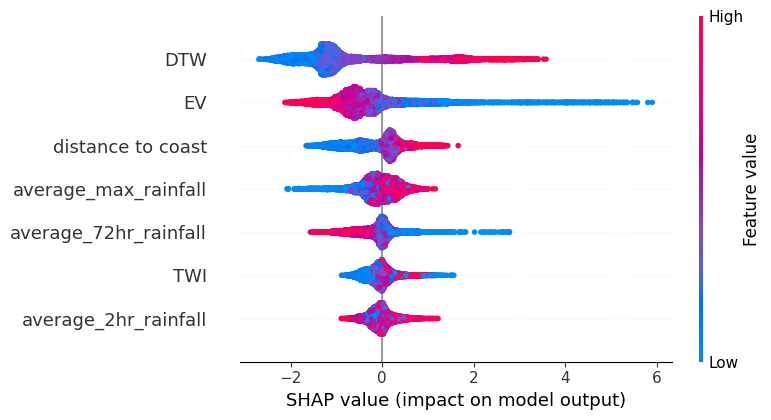

In [ ]:
# TREESHAP

# 初始化SHAP解释器并计算特征重要性，在预测集上分析
explainer = shap.Explainer(model_xgb)
shap_values = explainer(all_output_pred_xgb_correct.iloc[:, 1:-4])

# 绘制汇总图表显示每个特征的重要性
shap.summary_plot(shap_values, all_output_pred_xgb_correct.iloc[:, 1:-4])

# 指标1 runtime 解释1000个预测样本所需的时间

# 指标2 local accuracy 1000个样本中，与模型输出的差异的归一化标准偏差

# 指标3 Consistency guarantees 一致性保证是解释方法的一个理论属性，它确保成对的案例永远一致（属性2）。我们把对这一属性的同意分成三个不同的类别：确切的保证、在无限抽样情况下成立的保证和没有保证。

# 指标4 Keep positive (mask) 指标衡量的是解释方法找到使模型输出增加最多的特征的能力。增加模型输出最多的特征。对于一个单一的输入，最积极的输入特征被保留在它们的原始值上，而所有其他的输入特征被掩盖在它们的平均值上。
# github库 Captum


In [ ]:
# KernelSHAP

In [ ]:
# Individual Conditional Expectation (ICE) https://github.com/AustinRochford/PyCEbox

In [ ]:
# Counterfactual Explanations https://github.com/interpretml/DiCE

In [ ]:
# LIME GitHub代码找到 https://github.com/marcotcr/lime

In [ ]:
# saabas可以加上,nmL那篇文章都加了，我们也可以加，https://github.com/andosa/treeinterpreter
